In [1]:
import feedparser
import requests
import re
import pandas as pd
import time
import smtplib
from email.mime.text import MIMEText
from typing import List, Dict, Any
import os
import json
import numpy as np

# --- CONFIGURATION ---
ANSSI_FEEDS = [
    ("Avis", "https://www.cert.ssi.gouv.fr/avis/feed/"),
    ("Alerte", "https://www.cert.ssi.gouv.fr/alerte/feed/")
]
RATE_LIMIT_SECONDS = 2
CSV_OUTPUT = "consolidated_anssi_cve.csv"

In [2]:
# --- STEP 1: Extract ANSSI RSS Feeds ---
def extract_anssi_feeds() -> List[Dict[str, Any]]:
    bulletins = []
    for bulletin_type, url in ANSSI_FEEDS:
        print(f"Extraction du flux RSS pour {bulletin_type} depuis {url}...")
        feed = feedparser.parse(url)
        for entry in feed.entries:
            # Robust extraction of ANSSI ID from link or id
            link = str(getattr(entry, 'link', ''))
            id_anssi = ''
            if link:
                parts = link.rstrip('/').split('/')
                if len(parts) > 1:
                    id_anssi = parts[-1] if parts[-1] else parts[-2]
            if not id_anssi and hasattr(entry, 'id'):
                id_anssi = str(entry.id)
            bulletins.append({
                "id_anssi": id_anssi,
                "titre_anssi": entry.title,
                "type": bulletin_type,
                "date": entry.published,
                "link": link
            })
    print(f"Nombre total de bulletins extraits : {len(bulletins)}")
    return bulletins

In [3]:
# --- STEP 2: Extract CVEs from ANSSI bulletin web page ---
def extract_cves_from_bulletin(bulletin: Dict[str, Any]) -> List[Dict[str, Any]]:
    print(f"Extraction des CVE depuis le bulletin : {bulletin['id_anssi']} ({bulletin['titre_anssi']})")
    cve_list = []
    try:
        # Download the bulletin web page
        response = requests.get(bulletin["link"], timeout=10)
        html = response.text
        # Extract CVE identifiers using regex
        cve_pattern = r"CVE-\d{4}-\d{4,7}"  # FIXED: single backslash for regex
        cve_list = list(set(re.findall(cve_pattern, html)))
        print(f"Nombre de CVE trouvés : {len(cve_list)}")
        return [{"cve": cve, "html": html} for cve in cve_list]
    except Exception as e:
        print(f"Erreur lors de l'extraction des CVE depuis la page web: {e}")
        return []

In [4]:
# --- STEP 3: Enrich CVE with MITRE and EPSS APIs ---
def enrich_cve(cve_id: str) -> Dict[str, Any]:
    print(f"Enrichissement des données pour la CVE : {cve_id}")
    # MITRE CVE API
    mitre_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
    cve_info = {
        "cvss": None, "base_severity": None, "cwe": None, "cwe_desc": None,
        "description": None, "vendor": None, "product": None, "versions": ""
    }
    try:
        r = requests.get(mitre_url, timeout=10)
        data = r.json()
        cna = data["containers"]["cna"]
        cve_info["description"] = cna["descriptions"][0]["value"] if cna.get("descriptions") else None
        # CVSS
        metrics = cna.get("metrics", [])
        if metrics:
            for metric in metrics:
                for key in metric:
                    if key.startswith("cvssV3"):
                        cve_info["cvss"] = metric[key].get("baseScore")
                        cve_info["base_severity"] = metric[key].get("baseSeverity")
        # CWE
        problemtype = cna.get("problemTypes", [])
        if problemtype and "descriptions" in problemtype[0]:
            cve_info["cwe"] = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cve_info["cwe_desc"] = problemtype[0]["descriptions"][0].get("description", "Non disponible")
        # Vendor/Product/Versions
        affected = cna.get("affected", [])
        if affected:
            cve_info["vendor"] = affected[0].get("vendor")
            cve_info["product"] = affected[0].get("product")
            versions = [v["version"] for v in affected[0].get("versions", []) if v.get("status") == "affected"]
            cve_info["versions"] = ", ".join(versions) if versions else ""
    except Exception as e:
        print(f"Erreur enrichissement MITRE pour {cve_id}: {e}")
    # EPSS API
    epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
    try:
        r = requests.get(epss_url, timeout=10)
        data = r.json()
        epss_data = data.get("data", [])
        cve_info["epss"] = epss_data[0]["epss"] if epss_data else None
    except Exception as e:
        print(f"Erreur enrichissement EPSS pour {cve_id}: {e}")
        cve_info["epss"] = None
    print(f"Enrichissement terminé pour {cve_id}")
    return cve_info

In [5]:
# --- STEP 4: Consolidate Data ---
def consolidate_data():
    print("Consolidation des données dans le DataFrame...")
    bulletins = extract_anssi_feeds()
    all_rows = []
    for i, bulletin in enumerate(bulletins, 1):
        print(f"Traitement du bulletin {i}/{len(bulletins)} : {bulletin['id_anssi']}")
        cves = extract_cves_from_bulletin(bulletin)
        for j, cve_entry in enumerate(cves, 1):
            print(f"  Traitement de la CVE {j}/{len(cves)} pour ce bulletin...")
            cve_id = cve_entry["cve"]
            cve_info = enrich_cve(cve_id)
            row = {
                "ID ANSSI": bulletin["id_anssi"],
                "Titre ANSSI": bulletin["titre_anssi"],
                "Type": bulletin["type"],
                "Date": bulletin["date"],
                "CVE": cve_id,
                "CVSS": cve_info["cvss"],
                "Base Severity": cve_info["base_severity"],
                "CWE": cve_info["cwe"],
                "CWE Description": cve_info["cwe_desc"],
                "EPSS": cve_info["epss"],
                "Lien": bulletin["link"],
                "Description": cve_info["description"],
                "Éditeur": cve_info["vendor"],
                "Produit": cve_info["product"],
                "Versions affectées": cve_info["versions"]
            }
            all_rows.append(row)
            time.sleep(RATE_LIMIT_SECONDS)
    print(f"Nombre total de lignes consolidées : {len(all_rows)}")
    df = pd.DataFrame(all_rows)
    df.to_csv(CSV_OUTPUT, index=False)
    print(f"CSV consolidé écrit dans {CSV_OUTPUT}")
    return df

In [6]:
# --- UTILITY FUNCTIONS ---
def get_file_list(path: str) -> list:
    """Returns a list of files in a directory."""
    try:
        return os.listdir(path)
    except Exception as e:
        print(f"Error reading directory {path}: {e}")
        return []

def parse_json_file(filepath: str) -> dict:
    """Loads and returns JSON data from a file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return {}

def extract_cve_info(data: dict, entry_id: str, entry_type: str, first_list: list, mitre_list: list, path: str) -> list:
    """Extracts CVE info from a single alert/avis JSON."""
    cve_list = []
    for cve in data.get("cves", []):
        cve_id = cve['name']
        dico = {
            'id': entry_id,
            'title': '',
            'type': entry_type,
            'publication_date': None,
            'cve_id': cve_id,
            'original_link': None,
            'epss': np.nan,
            'description': None,
            'cwe': 'Non disponible',
            'cwe_desc': 'Non disponible',
            'vendor': [],
            'product': [],
            'affected_versions': [],
            'cvss': np.nan,
            'severity': None
        }
        # Info from vendor_advisories (safe access)
        vendor_advisories = data.get('vendor_advisories', [])
        if vendor_advisories and isinstance(vendor_advisories, list):
            vendor_adv = vendor_advisories[0]
            dico['title'] = vendor_adv.get('title', '')
            dico['publication_date'] = vendor_adv.get('published_at')
            dico['original_link'] = vendor_adv.get('url')
        # Info from first
        if cve_id in first_list:
            data_first = parse_json_file(os.path.join(path, "first", cve_id))
            if data_first.get('data') and 'epss' in data_first['data'][0]:
                dico['epss'] = data_first['data'][0]['epss']
        # Info from mitre
        if cve_id in mitre_list:
            data_mitre = parse_json_file(os.path.join(path, "mitre", cve_id))
            cna = data_mitre.get('containers', {}).get('cna', {})
            if 'descriptions' in cna:
                dico['description'] = cna['descriptions'][0].get('value')
            # CWE
            problemtype = cna.get('problemTypes', [{}])
            if problemtype and 'descriptions' in problemtype[0]:
                dico['cwe'] = problemtype[0]['descriptions'][0].get('cweId', 'Non disponible')
                dico['cwe_desc'] = problemtype[0]['descriptions'][0].get('description', 'Non disponible')
            # Affected products
            for product in cna.get('affected', []):
                if 'vendor' in product:
                    dico['vendor'].append(product['vendor'])
                if 'product' in product:
                    dico['product'].append(product['product'])
                if 'versions' in product:
                    dico['affected_versions'] = [v["version"] for v in product["versions"] if v["status"] == "affected"]
            # CVSS and severity
            keys = ['cvssV3_0', 'cvssV3_1', 'cvssV2', 'cvssV4_0']
            metrics = cna.get('metrics', [{}])
            if metrics:
                cvss_info = metrics[0]
                for key in keys:
                    if key in cvss_info:
                        dico['cvss'] = cvss_info[key].get('baseScore', np.nan)
                        dico['severity'] = cvss_info[key].get('baseSeverity')
        cve_list.append(dico)
    return cve_list

def build_cve_list(base_path: str) -> list:
    """Builds the consolidated CVE list from avis and alertes."""
    avis_list = get_file_list(os.path.join(base_path, "Avis"))
    alert_list = get_file_list(os.path.join(base_path, "alertes"))
    mitre_list = get_file_list(os.path.join(base_path, "mitre"))
    first_list = get_file_list(os.path.join(base_path, "first"))
    cve_list = []
    for avis_id in avis_list:
        data = parse_json_file(os.path.join(base_path, "Avis", avis_id))
        cve_list.extend(extract_cve_info(data, avis_id, 'Avis', first_list, mitre_list, base_path))
    for alert_id in alert_list:
        data = parse_json_file(os.path.join(base_path, "alertes", alert_id))
        cve_list.extend(extract_cve_info(data, alert_id, 'Alerte', first_list, mitre_list, base_path))
    return cve_list

In [7]:
# --- STEP 6: Alert Generation and Email Notification ---
def send_email(to_email, subject, body):
    from_email = "votre_email@gmail.com"
    password = "mot_de_passe_application"
    msg = MIMEText(body)
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, password)
    server.sendmail(from_email, to_email, msg.as_string())
    server.quit()

def generate_alerts_and_notify(df: pd.DataFrame, product_filter: str, email: str):
    critical = df[(df['Base Severity'] == 'Critical') & (df['Produit'].str.contains(product_filter, na=False))]
    if not critical.empty:
        for _, row in critical.iterrows():
            subject = f"Alerte CVE critique: {row['Produit']}"
            body = f"CVE: {row['CVE']}\nDescription: {row['Description']}\nScore CVSS: {row['CVSS']}\nLien: {row['Lien']}"
            send_email(email, subject, body)
            print(f"Envoi d'une alerte pour {row['Produit']} à {email}")

In [10]:
if __name__ == "__main__":
    # Utiliser la consolidation locale des données déjà enrichies à partir des dossiers mitre et first
    base_path = os.path.join(os.getcwd(), "data_pour_TD_final")
    cve_list = build_cve_list(base_path)
    print(f"Nombre total de CVE consolidés : {len(cve_list)}")
    # Afficher un exemple
    if cve_list:
        print("Exemple de CVE :", cve_list[0])
        df = pd.DataFrame(cve_list)
    # Vous pouvez ensuite convertir en DataFrame ou exporter selon vos besoins
    # df = pd.DataFrame(cve_list)
    # df.to_csv("consolidated_all_cve.csv", index=False)
    print("Traitement terminé avec les nouvelles fonctions.")


Nombre total de CVE consolidés : 60799
Exemple de CVE : {'id': 'CERTFR-2023-AVI-0963', 'title': 'Bulletin de sécurité Cisco cisco-sa-http2-reset-d8Kf32vZ du 16 octobre 2023', 'type': 'Avis', 'publication_date': None, 'cve_id': 'CVE-2023-44487', 'original_link': 'https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-http2-reset-d8Kf32vZ', 'epss': '0.944340000', 'description': 'The HTTP/2 protocol allows a denial of service (server resource consumption) because request cancellation can reset many streams quickly, as exploited in the wild in August through October 2023.', 'cwe': 'Non disponible', 'cwe_desc': 'n/a', 'vendor': ['n/a'], 'product': ['n/a'], 'affected_versions': ['n/a'], 'cvss': nan, 'severity': None}
Traitement terminé avec les nouvelles fonctions.


# Étape 5 : Interprétation et Visualisation des Vulnérabilités

Nous allons utiliser le DataFrame `df` déjà présent en mémoire pour explorer et visualiser les vulnérabilités.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# df doit déjà être défini dans l'environnement
df.head()

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity
0,CERTFR-2023-AVI-0963,Bulletin de sécurité Cisco cisco-sa-http2-rese...,Avis,None,CVE-2023-44487,https://sec.cloudapps.cisco.com/security/cente...,0.944340000,The HTTP/2 protocol allows a denial of service...,Non disponible,n/a,[n/a],[n/a],[n/a],NaN,None
1,CERTFR-2025-AVI-0119,Bulletin de sécurité Intel INTEL-SA-01139,Avis,2025-02-10,CVE-2024-38310,https://www.intel.com/content/www/us/en/securi...,0.000150000,Improper access control in some Intel(R) Graph...,Non disponible,Escalation of Privilege,[n/a],[Intel(R) Graphics Driver software installers],[See references],5.4,MEDIUM
2,CERTFR-2025-AVI-0119,Bulletin de sécurité Intel INTEL-SA-01139,Avis,2025-02-10,CVE-2024-25571,https://www.intel.com/content/www/us/en/securi...,0.000200000,Improper input validation in some Intel(R) SPS...,Non disponible,Denial of Service,[n/a],[Intel(R) SPS firmware before SPS_E5_06.01.04....,[See references],4.6,MEDIUM
3,CERTFR-2025-AVI-0119,Bulletin de sécurité Intel INTEL-SA-01139,Avis,2025-02-10,CVE-2023-34440,https://www.intel.com/content/www/us/en/securi...,0.000280000,Improper input validation in UEFI firmware for...,Non disponible,Escalation of Privilege,[n/a],[Intel(R) Processors],[See references],8.7,HIGH
4,CERTFR-2025-AVI-0119,Bulletin de sécurité Intel INTEL-SA-01139,Avis,2025-02-10,CVE-2024-37020,https://www.intel.com/content/www/us/en/securi...,0.000270000,Sequence of processor instructions leads to un...,Non disponible,Denial of Service,[n/a],[Intel(R) Xeon(R) Processors],[See references],4.9,MEDIUM


## 1. Histogramme des scores CVSS

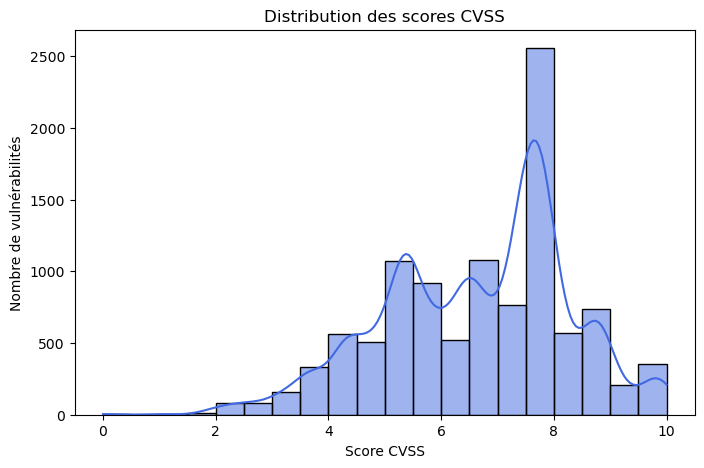

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['cvss'].dropna(), bins=20, kde=True, color='royalblue')
plt.title('Distribution des scores CVSS')
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de vulnérabilités')
plt.show()

## 2. Diagramme circulaire des types de vulnérabilités (CWE)

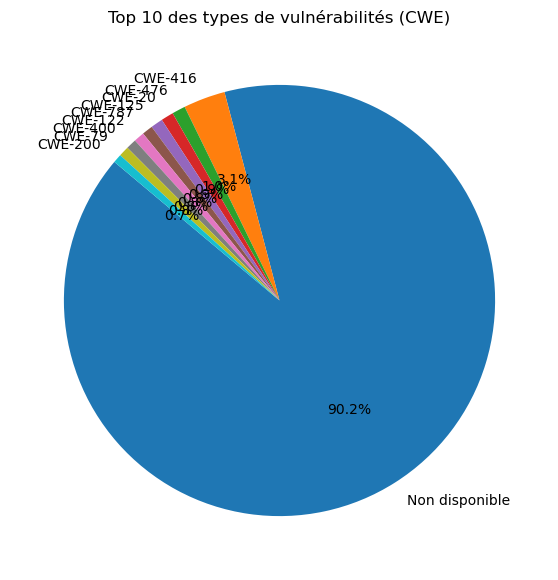

In [15]:
cwe_counts = df['cwe'].value_counts().head(10)
plt.figure(figsize=(7,7))
plt.pie(cwe_counts, labels=cwe_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 des types de vulnérabilités (CWE)')
plt.show()

## 3. Courbe des scores EPSS

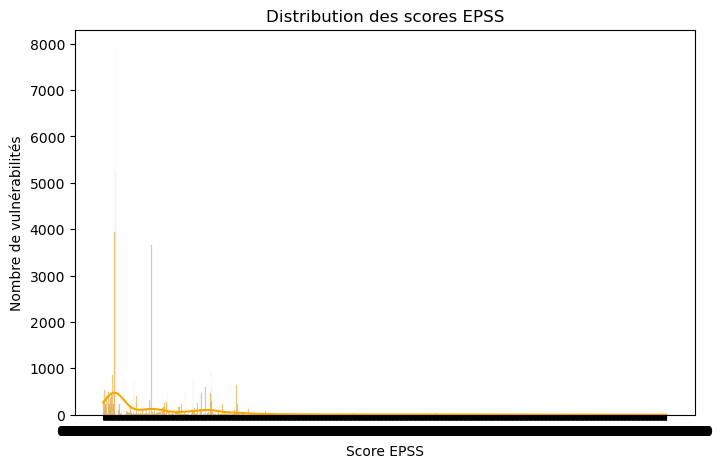

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['epss'].dropna(), bins=20, kde=True, color='orange')
plt.title('Distribution des scores EPSS')
plt.xlabel('Score EPSS')
plt.ylabel('Nombre de vulnérabilités')
plt.show()

## 4. Classement des produits les plus affectés

/var/folders/c9/d2c7dwqd5nj815qdtryfh3zw0000gn/T/ipykernel_35448/108380907.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


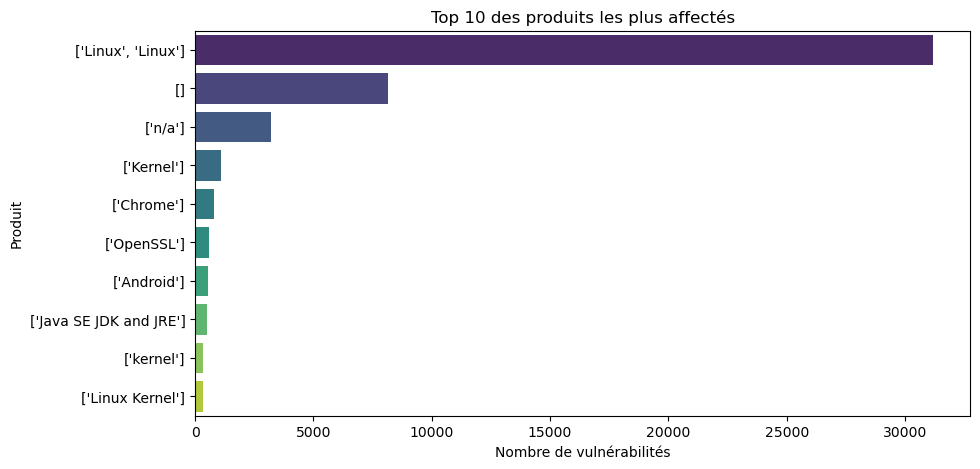

In [18]:
df['Produit_str'] = df['product'].astype(str)
top_products = df['Produit_str'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 des produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.ylabel('Produit')
plt.show()

## 5. Nuage de points entre Score CVSS et Score EPSS

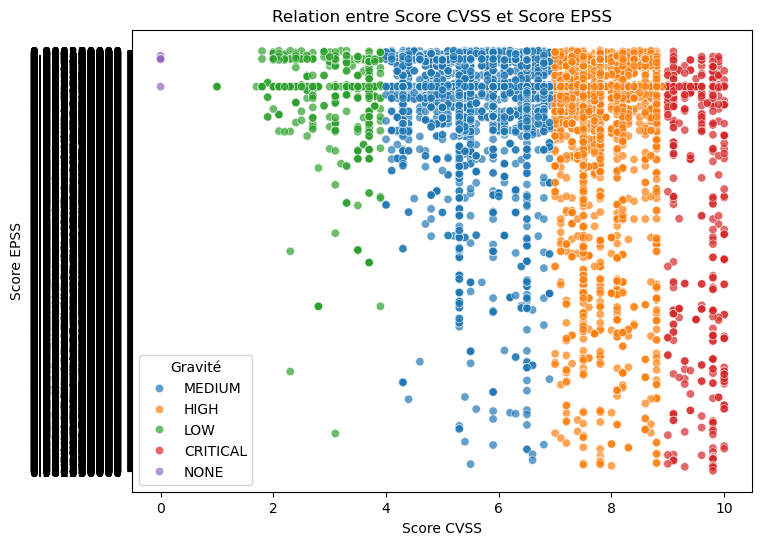

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='cvss', y='epss', hue='severity', alpha=0.7)
plt.title('Relation entre Score CVSS et Score EPSS')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS')
plt.legend(title='Gravité')
plt.show()

## 6. Courbe cumulative des vulnérabilités en fonction du temps

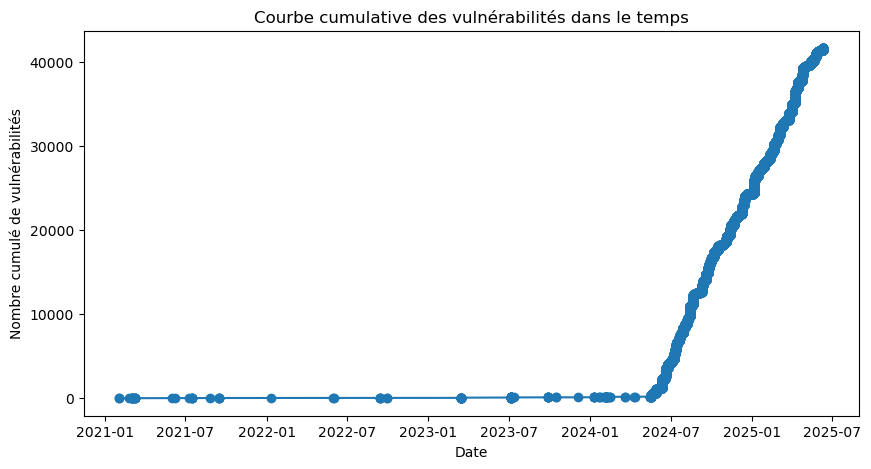

In [22]:
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df_sorted = df.sort_values('publication_date')
df_sorted['cumulative'] = range(1, len(df_sorted)+1)
plt.figure(figsize=(10,5))
plt.plot(df_sorted['publication_date'], df_sorted['cumulative'], marker='o')
plt.title('Courbe cumulative des vulnérabilités dans le temps')
plt.xlabel('Date')
plt.ylabel('Nombre cumulé de vulnérabilités')
plt.show()

## 7. Boxplot des scores CVSS par éditeur

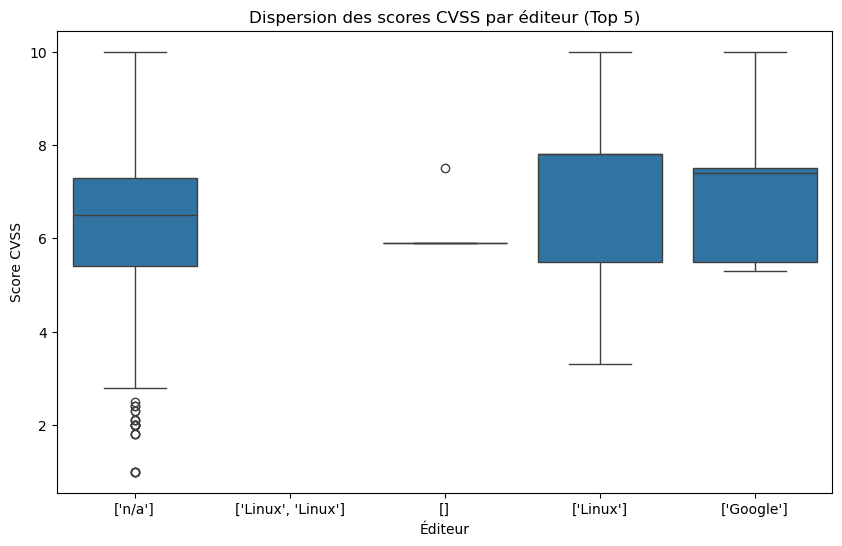

In [24]:
df['vendor'] = df['vendor'].astype(str)
top_editors = df['vendor'].value_counts().head(5).index
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['vendor'].isin(top_editors)], x='vendor', y='cvss')
plt.title('Dispersion des scores CVSS par éditeur (Top 5)')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.show()

N'hésitez pas à adapter ces visualisations ou à en créer d'autres selon vos besoins d'analyse !

N'hésitez pas à adapter ces visualisations ou à en créer d'autres selon vos besoins d'analyse !